In [39]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [40]:
! nvidia-smi

Sun Dec 15 05:33:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             33W /  250W |   15795MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
import datetime 
print(f"Notebook last run (end-to-end) :{datetime.datetime.now()}")

Notebook last run (end-to-end) :2024-12-15 05:33:10.212138


In [42]:
# loading helper functions
! wget https://raw.githubusercontent.com/shubham-murtadak/Deep_Learning_with-Tensorflow/refs/heads/main/Extras/helper_functions.py

--2024-12-15 05:33:11--  https://raw.githubusercontent.com/shubham-murtadak/Deep_Learning_with-Tensorflow/refs/heads/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-15 05:33:11 (84.2 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [43]:
# Import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

# 101 Food Classes: Working with less data (10% data) all categories

In [44]:
# Downloading and preprocessing the data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-12-15 05:33:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 74.125.139.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip.1'

101_food_classes_10 100%[===================>]   1.51G   316MB/s    in 4.9s    

2024-12-15 05:33:17 (313 MB/s) - '101_food_classes_10_percent.zip.1' saved [1625420029/1625420029]



In [45]:

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_p

In [46]:
# setup data inputs
IMG_SIZE=(224,224)

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             label_mode='categorical',
                                                                             image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False
                                                             )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

In [47]:
# create checkpoint callback to save model for later use 
checkpoint_path="101_classes_10_percent_data_model_checkpoint.weights.h5"

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True
                                                      )

In [48]:
# creating dataaugmentation Sequential model and inserting it as a layer

data_augmentation=Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
],name="data_augmentation"
                            )

In [49]:
# setup the base model(EfficientNetB0) and freeze its layers (this will extract features)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# setup model architecute with trainable top layers
inputs=layers.Input(shape=(224,224,3),name='input_layer')

x=data_augmentation(inputs)

x=base_model(x,training=False) 

x=layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)

In [50]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [51]:
# compile model 
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy']
             )

# fit the model 
history_all_classes_10_percent=model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5


2024-12-15 05:33:44.251278: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step - accuracy: 0.1280 - loss: 4.0789 - val_accuracy: 0.3414 - val_loss: 2.8225
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.4053 - loss: 2.6149 - val_accuracy: 0.4938 - val_loss: 2.1067
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.4811 - loss: 2.2068 - val_accuracy: 0.5660 - val_loss: 1.7961
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.5181 - loss: 1.9852 - val_accuracy: 0.4967 - val_loss: 1.8780
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.5456 - loss: 1.8213 - val_accuracy: 0.6765 - val_loss: 1.3116


In [52]:
# Evaluate model 
results_feature_extraction_model=model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5091 - loss: 1.9037


[1.8162580728530884, 0.5287524461746216]

### we just beat our baseline (the results from the original Food101 paper) with 10% of the data!

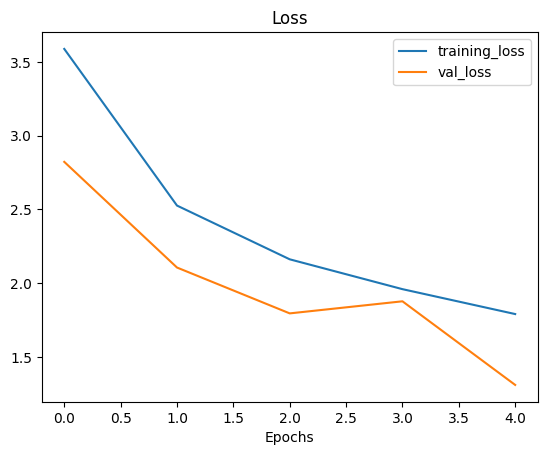

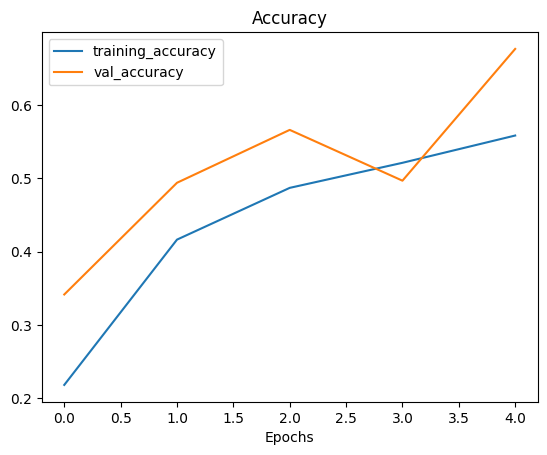

In [53]:
#plot curves 
plot_loss_curves(history_all_classes_10_percent)

# Lets do finetuning 

In [54]:
# unfreeze all of the layers in the base model 
base_model.trainable=True

# Refreeze every layer except for the last 5 
for layer in base_model.layers[:-5]:
    layer.trainable=False 

In [55]:
# Recompile model with lower learning rate 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']
             )

In [56]:
# lets check which layers are trainable 
for layer in model.layers:
    print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [57]:


# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

## Final Flow in Reality
* Training Phase: Process each batch → Forward pass → Loss * Backpropagation → Weight update.
* Validation Phase: Forward pass only → Compute validation metrics.
* Repeat for each epoch until training is complete.

In [58]:
# lets fine tuned model 
fine_tune_epochs=10 

history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1]
                                                  )

Epoch 5/10


2024-12-15 05:36:41.313733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.5696 - loss: 1.7909 - val_accuracy: 0.4947 - val_loss: 1.9825
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.6116 - loss: 1.5872 - val_accuracy: 0.5289 - val_loss: 1.7823
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.6384 - loss: 1.4813 - val_accuracy: 0.6062 - val_loss: 1.5713
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.6459 - loss: 1.4422 - val_accuracy: 0.5755 - val_loss: 1.6298
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.6687 - loss: 1.3542 - val_accuracy: 0.6269 - val_loss: 1.4335
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.6882 - loss: 1.2833 - val_accuracy: 0.6030 - val_loss: 1.4521


In [59]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5506 - loss: 1.7114


[1.6065402030944824, 0.5753267407417297]

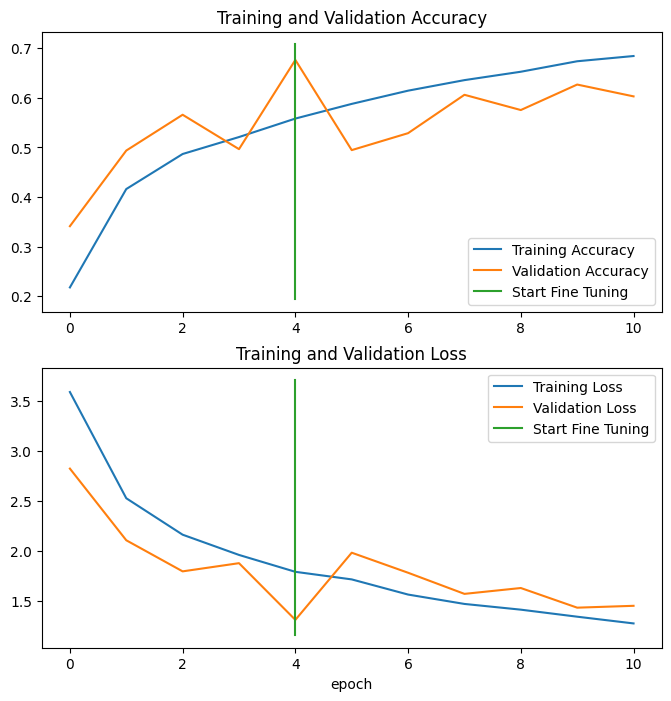

In [60]:

compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving our trained model

In [61]:
import os 
os.makedirs("/kaggle/working/models", exist_ok=True)
model.save("/kaggle/working/models/101_food_class_10_percent_saved_big_dog_model.keras")


# Evaluating the performance of the big dog model across all different classes

## Making predictions with our trained modell

In [62]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 
     

790/790 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step


In [63]:


# How many predictions are there?
len(pred_probs)

25250

In [64]:

# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [65]:


# How do they look?
pred_probs[:10]

array([[1.74073964e-01, 7.40396790e-04, 1.46094531e-01, ...,
        2.96196551e-04, 1.61900243e-03, 2.78744344e-02],
       [9.21373308e-01, 1.04462720e-06, 1.20396272e-03, ...,
        2.29532714e-03, 1.93430651e-06, 5.95989104e-06],
       [2.77161717e-01, 6.57759793e-03, 5.13738673e-03, ...,
        1.30761124e-03, 7.10315828e-04, 1.91096705e-03],
       ...,
       [3.91454309e-01, 3.01856398e-05, 3.67733790e-03, ...,
        8.15149248e-02, 7.98159337e-04, 3.91487672e-04],
       [1.96891204e-01, 1.49558450e-03, 9.73241925e-02, ...,
        2.00999063e-03, 3.24808352e-04, 4.31293127e-04],
       [5.71715057e-01, 3.05241665e-05, 2.21070391e-03, ...,
        1.10897515e-02, 7.49512546e-05, 2.07684725e-03]], dtype=float32)

In [66]:

# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")
     

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.74073964e-01 7.40396790e-04 1.46094531e-01 2.01586954e-06
 1.38127643e-05 1.97119680e-05 1.01930718e-03 1.05400984e-04
 5.28744571e-02 1.44720520e-03 1.94932818e-05 1.86093937e-04
 5.73520130e-03 5.97169128e-06 3.44733857e-02 1.19067414e-03
 7.13083253e-04 1.91323517e-03 6.64181600e-04 2.23964835e-05
 7.51481333e-04 3.40873026e-04 1.16500922e-03 1.53636839e-03
 8.26338714e-04 1.62892183e-03 1.25552632e-03 1.80052812e-05
 6.23916313e-02 2.22686818e-03 2.71670233e-05 1.68952998e-03
 2.80434615e-03 1.89891842e-04 1.13777397e-02 1.47191982e-04
 8.44858878e-04 4.33261925e-03 1.19012892e-02 1.25423496e-04
 9.62246559e-04 3.88872460e-04 4.27775923e-03 3.64574407e-05
 1.98275404e-04 1.05503772e-03 1.42905419e-03 2.24916788e-04
 6.34170938e-05 5.37749939e-03 2.66665011e-03 3.54703079e-05
 2.54571766e-01 7.31900241e-03 3.16687001e-05 1.74988005e-02
 4.94844746e-03 3.22413538e-03 2.30780169e-

In [67]:


# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 38,  8, 78, 29,  0,  9,  0])

In [68]:

# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)
     

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [69]:


# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

## Evaluating our models predictions

In [70]:

# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5753267326732673

In [72]:
from helper_functions import make_confusion_matrix

In [73]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [74]:

# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [75]:

# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)
     

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.16      0.21       250
           1       0.49      0.71      0.58       250
           2       0.57      0.53      0.55       250
           3       0.81      0.49      0.61       250
           4       0.53      0.43      0.48       250
           5       0.41      0.34      0.38       250
           6       0.76      0.69      0.72       250
           7       0.77      0.77      0.77       250
           8       0.24      0.54      0.33       250
           9       0.35      0.61      0.45       250
          10       0.43      0.41      0.42       250
          11       0.73      0.54      0.62       250
          12       0.71      0.53      0.61       250
          13       0.48      0.58      0.52       250
          14       0.49      0.52      0.50       250
          15       0.38      0.36      0.37       250
          16       0.65      0.49      0.56       250
          17       0.38    

In [77]:

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.28776978417266186,
  'recall': 0.16,
  'f1-score': 0.20565552699228792,
  'support': 250},
 '1': {'precision': 0.4876712328767123,
  'recall': 0.712,
  'f1-score': 0.5788617886178862,
  'support': 250},
 '2': {'precision': 0.5683760683760684,
  'recall': 0.532,
  'f1-score': 0.5495867768595042,
  'support': 250},
 '3': {'precision': 0.8133333333333334,
  'recall': 0.488,
  'f1-score': 0.61,
  'support': 250},
 '4': {'precision': 0.5346534653465347,
  'recall': 0.432,
  'f1-score': 0.4778761061946903,
  'support': 250},
 '5': {'precision': 0.41346153846153844,
  'recall': 0.344,
  'f1-score': 0.37554585152838427,
  'support': 250},
 '6': {'precision': 0.7577092511013216,
  'recall': 0.688,
  'f1-score': 0.7211740041928721,
  'support': 250},
 '7': {'precision': 0.7710843373493976,
  'recall': 0.768,
  'f1-score': 0.7695390781563127,
  'support': 250},
 '8': {'precision': 0.24100719424460432,
  'recall': 0.536,
  'f1-score': 0.33250620347394544,
  'support': 250},
 

In [78]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.20565552699228792,
 'baby_back_ribs': 0.5788617886178862,
 'baklava': 0.5495867768595042,
 'beef_carpaccio': 0.61,
 'beef_tartare': 0.4778761061946903,
 'beet_salad': 0.37554585152838427,
 'beignets': 0.7211740041928721,
 'bibimbap': 0.7695390781563127,
 'bread_pudding': 0.33250620347394544,
 'breakfast_burrito': 0.4470588235294118,
 'bruschetta': 0.4188911704312115,
 'caesar_salad': 0.6238532110091743,
 'cannoli': 0.6073059360730594,
 'caprese_salad': 0.5245901639344263,
 'carrot_cake': 0.5029013539651838,
 'ceviche': 0.36550308008213556,
 'cheese_plate': 0.560364464692483,
 'cheesecake': 0.41516245487364617,
 'chicken_curry': 0.4246575342465754,
 'chicken_quesadilla': 0.5819861431870671,
 'chicken_wings': 0.696588868940754,
 'chocolate_cake': 0.5196506550218339,
 'chocolate_mousse': 0.34730538922155685,
 'churros': 0.7324561403508772,
 'clam_chowder': 0.7212475633528265,
 'club_sandwich': 0.640495867768595,
 'crab_cakes': 0.3717171717171717,
 'creme_brulee': 0.7174348

In [79]:

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()
     

class_name  f1-score
33        edamame  0.960474
63       macarons  0.858407
75            pho  0.836000
86        sashimi  0.816635
45  frozen_yogurt  0.808765

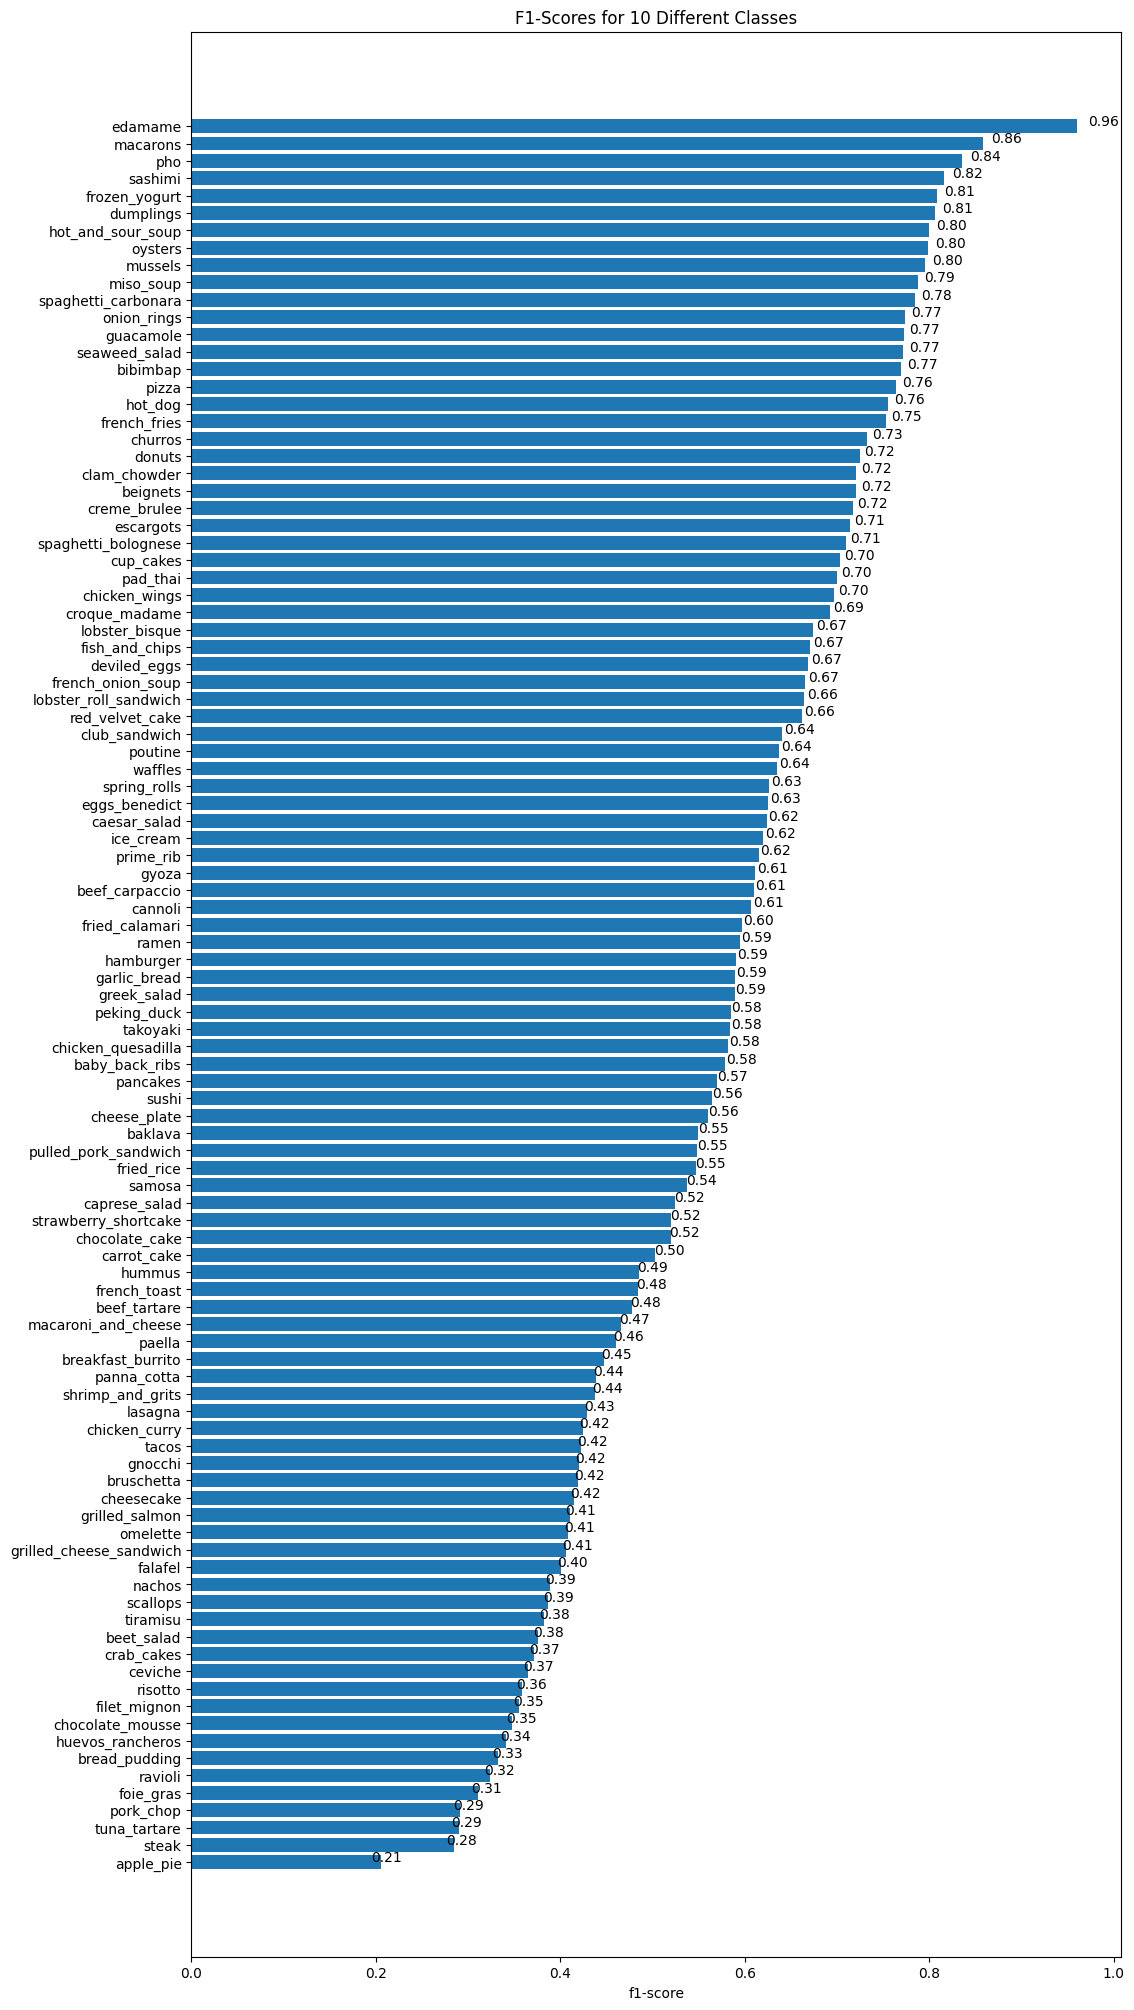

In [80]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [81]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


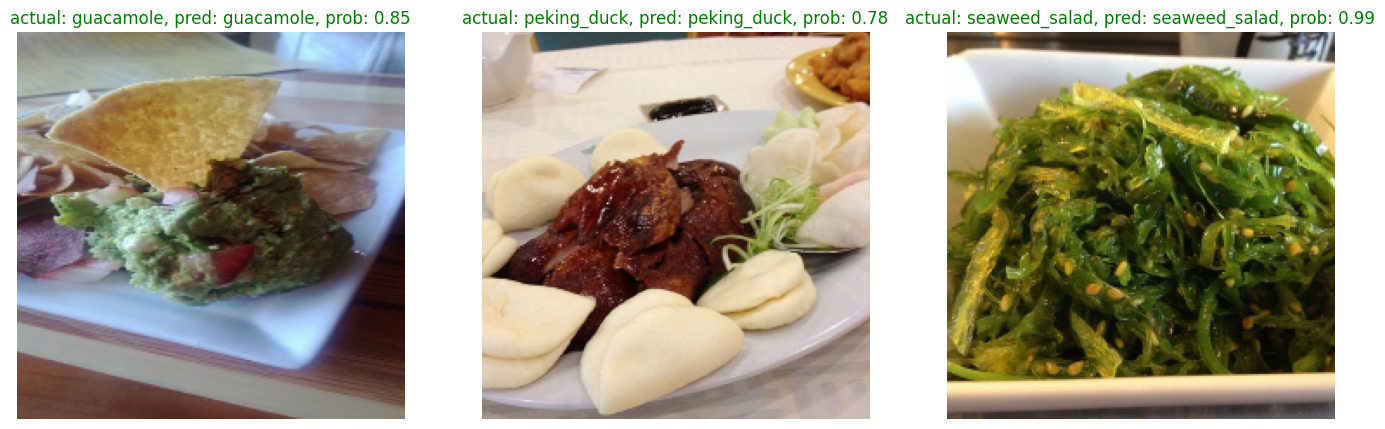

In [82]:

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [83]:

# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]
     

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [84]:

# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.254572        apple_pie            gyoza  
1   0.921373        apple_pie        apple_pie  
2   0.277162        apple_pie        apple_pie  
3   0.191474        apple_pie   fish_and_chips  
4   0.483388        apple_pie    bread_pudding

In [85]:

# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.254572        apple_pie            gyoza         False  
1   0.921373        apple_pie        apple_pie          True  
2   0.277162        apple_pie        apple_pie          True  
3   0.191474        apple_pie   fish_and_chips         False  
4   0.483388        apple_pie    bread_pudding         False

In [86]:

# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
22     b'101_food_classes_10_percent/test/apple_pie/1...       0     100   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
17816  b'101_food_classes_10_percent/test/paella/1762...      71      70   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
5829   b'101_food_classes_10_percent/test/churros/227...      23      68   
23935  b'101_food_classes_10_percent/test/sushi/46797...      95      86   
14062  b'101_food_classes_10_percent/test/huevos_ranc...      56      28   
9073   b'101_food_classes_10_percent/test/falafel/192...      36      26   
22511  b'101_food_classes_10_percent/test/spaghetti_b...      90      78   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23740  b'101_food_classes_10_percent/test/strawberry_...      94       8   
21216  b'101_food_classes_10_percent/test/risotto/493...      84      70   
22606  b'101_food_classes_10_percent/test/spaghetti_b...      90       1   
5652   b'101_food_classes_10_percent/test/chocolate_m...      22      98   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
16209  b'101_food_classes_10_percent/test/miso_soup/5...      64      81   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
23631   0.998895   strawberry_shortcake  red_velvet_cake         False  
22      0.995820              apple_pie          waffles         False  
10847   0.995721         fried_calamari      onion_rings         False  
23797   0.992793                  sushi          sashimi         False  
17816   0.991039                 paella         pad_thai         False  
18001   0.990773               pancakes         omelette         False  
15826   0.984450               macarons        cup_cakes         False  
5829    0.982624                churros      onion_rings         False  
23935   0.982319                  sushi          sashimi         False  
14062   0.982307       huevos_rancheros    croque_madame         False  
9073    0.980919                falafel       crab_cakes         False  
22511   0.980850    spaghetti_bolognese          poutine         False  
15359   0.980123  lobster_roll_sandwich        hamburger         False  
23740   0.979524   strawberry_shortcake    bread_pudding         False  
21216   0.979155                risotto         pad_thai         False  
22606   0.977313    spaghetti_bolognese   baby_back_ribs         False  
5652    0.976629       chocolate_mousse         tiramisu         False  
11642   0.976307           garlic_bread       bruschetta         False  
16209   0.974968              miso_soup            ramen         False  
231     0.974609              apple_pie          waffles         False

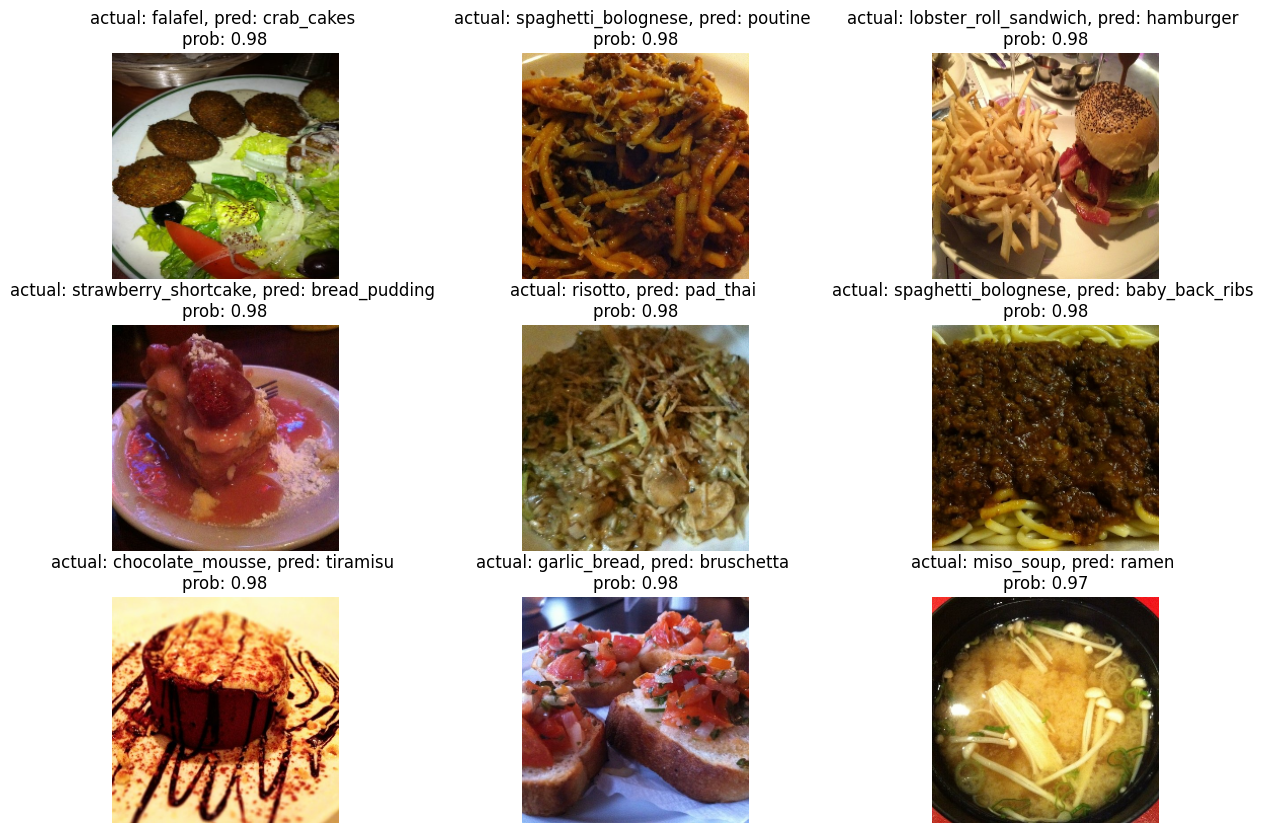

In [87]:

# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)
     

#### Test out the big dog model on test images as well as custom images of food

In [88]:

# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-15 05:51:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: 'custom_food_images.zip'

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2024-12-15 05:51:57 (94.1 MB/s) - 'custom_food_images.zip' saved [13192985/13192985]



In [89]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images
     

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


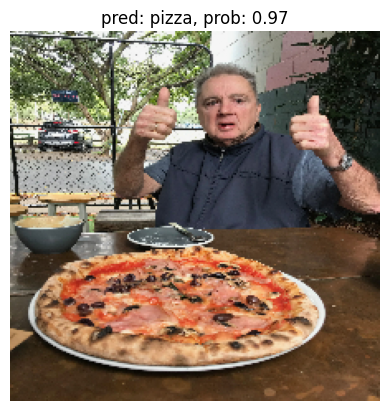

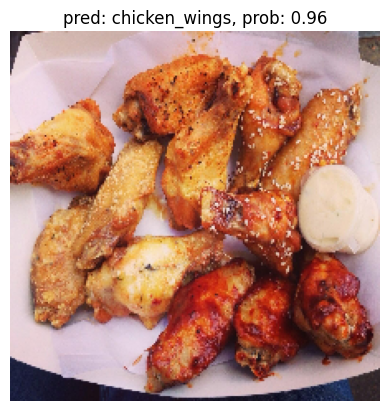

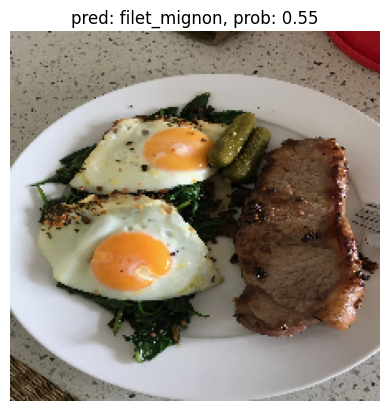

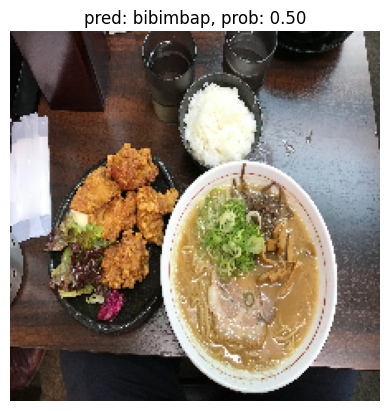

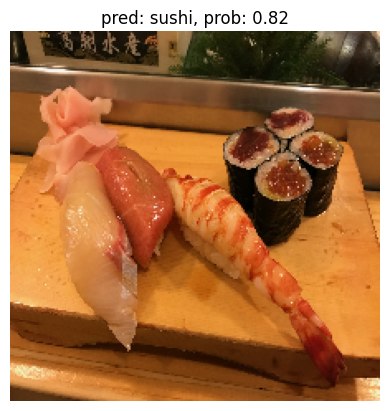

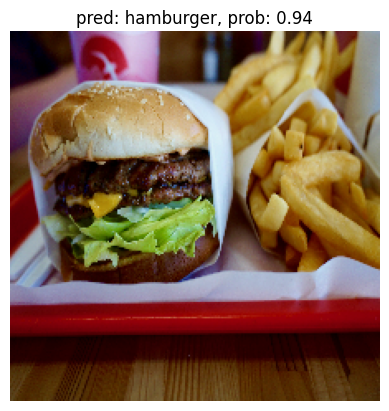

In [90]:

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)
     